---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---
##### José Pablo Araya Garbanzo
##### B80508


# `L5` - *Cadenas de Markov*

> El caso especial de los procesos aleatorios donde existen "estados" y "transiciones" entre estos estados, las cadenas de Markov modelan las probabilidades de transición y el tiempo de permanencia entre cada estado. En particular, la teoría de colas describe la evolución del número de elementos en la fila, dado un flujo de entrada y un flujo de salida.

---

## Sistemas M/M/1

Con una tasa de llegada $\lambda$ y un parámetro de tiempo de servicio $\nu$, un proceso de Markov con un solo servidor también recibe la notación de *sistema de colas* **M/M/1** (donde la M viene de Markov). Más en general, con $s$ servidores es un sistema **M/M/s**.

La simulación de un sistema del tipo **M/M/1** implica la generación de una llegada de "clientes" como una *corriente de Poisson*. Esto es equivalente a decir que tienen una distribución de probabilidad de *tiempo entre arribos* con distribución exponencial y parámetro $\lambda$.

Por su parte, el *tiempo de servicio* tiene también una distribución exponencial pero con parámetro $\nu$. A la relación $\lambda/\nu$ usualmente se le conoce como $\rho$.

**Nota**: El tiempo de servicio se asume independiente del tiempo de llegada.

#### Sobre la simulación

Es posible crear una simulación de $N$ clientes con sus respectivos tiempos de servicio, distribuidos en el tiempo.

Para medir el tiempo se puede utilizar una medida mínima arbitraria, pero que tenga sentido para el problema. Por ejemplo: si la tasa de llegada es de 1 persona/minuto, vale más tener una granularidad de segundos o decenas de segundos para capturar una precisión temporal adecuada.

**Nota**: De la selección de $N$ puede depender la precisión deseada para el resultado. Por ejemplo: con $N = 1000$ es posible obtener una precisión de hasta el 0,001 o 0,1% ($1/N$).

### Problema de ejemplo: un servidor web

> Un servidor web es modelado como un sistema M/M/1 con una tasa de arribo de 2 solicitudes por minuto. Es deseado tener 4 o menos solicitudes en fila el 99\% del tiempo. ¿Qué tan rápido debe ser el servicio? $\nu$ es solicitudes atendidas por minuto.

El estado $i$ es el número de clientes en el sistema. La longitud de la fila es $L_q = i - 1$ (*queue length*), en virtud de la solicitud que está siendo atendida en $s = 1$ servidores. Es posible encontrar que:

$$
P( \text{5 o más clientes en el sistema} ) = \sum_{i=5}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{4} (1 - \rho) \rho^i = \rho^5
$$

que depende de $\rho = \lambda/\nu$ y del parámetro de servicio $\nu$ buscado. 

De los datos del problema: $\lambda = 2$. Para tener una fila de 3 o menos clientes el 99\% del tiempo se necesita:

$$
\begin{aligned}
P( \text{5 o más clientes en el sistema} ) = \rho^5 & = \left( \frac{\lambda}{\nu} \right)^5 \leq 0.01 \\
\nu^5 & \geq \frac{\lambda^5}{0.01} = \frac{2^5}{0.01} = 3200 \quad \Rightarrow \quad \nu \geq 5.024
\end{aligned}
$$

es decir, el servidor debe atender más de 5,024 solicitudes por minuto en promedio para poder satisfacer el requisito.

En la siguiente simulación, con $N = 1000$, y $\nu = 3 < 5.024$ deberíamos obtener una probabilidad $P( \text{5 o más clientes en el sistema} ) > 0.01$ que **no** cumple con las especificaciones.

**Nota**: Observar el cambio de unidades de minutos a segundos, para lograr mayor "granularidad".

Parámetro lambda = 2.0
Parámetro nu = 3.0
Tiempo con más de 3 solicitudes en fila:
	 12.78%
	 No cumple con la especificación.
Simulación es equivalente a 8.62 horas.


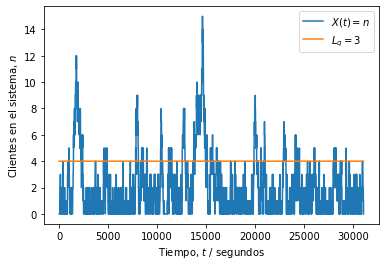

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Número de clientes
N = 1000

# Parámetro de llegada (clientes/segundos)
lam = 2/60

# Parámetro de servicio (servicios/segundos)
nu = 3/60

# Distribución de los tiempos de llegada entre cada cliente
X = stats.expon(scale = 1/lam)

# Distribución de los tiempos de servicio a cada cliente
Y = stats.expon(scale = 1/nu)

# Intervalos entre llegadas (segundos desde último cliente)
t_intervalos = np.ceil(X.rvs(N)).astype('int')

# Tiempos de las llegadas (segundos desde el inicio)
t_llegadas = [t_intervalos[0]]
for i in range(1, len(t_intervalos)):
    siguiente = t_llegadas[i-1] + t_intervalos[i]
    t_llegadas.append(siguiente)

# Tiempos de servicio (segundos desde inicio de servicio)
t_servicio = np.ceil(Y.rvs(N)).astype('int')

# Inicialización del tiempo de inicio y fin de atención
inicio = t_llegadas[0]          # primera llegada
fin = inicio + t_servicio[0]    # primera salida

# Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
t_atencion = [inicio]
for i in range(1, N):
    inicio = np.max((t_llegadas[i], fin))
    fin = inicio + t_servicio[i]
    t_atencion.append(inicio)

# Inicialización del vector temporal para registrar eventos
t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

# Asignación de eventos de llegada (+1) y salida (-1) de clientes
for c in range(N):
    i = t_llegadas[c]
    t[i] += 1
    j = t_atencion[c] + t_servicio[c]
    t[j] -= 1

# Umbral de P o más personas en sistema (hay P - 1 en fila)
P = 5

# Instantes (segundos) de tiempo con P o más solicitudes en sistema
frecuencia = 0

# Proceso aleatorio (estados n = {0, 1, 2...})
Xt = np.zeros(t.shape)

# Inicialización de estado n
n = 0

# Recorrido del vector temporal y conteo de clientes (estado n)
for i, c in enumerate(t):
    n += c # sumar (+1) o restar (-1) al estado
    Xt[i] = n
    if Xt[i] >= P: 
        frecuencia += 1

# Fracción de tiempo con P o más solicitudes en sistema
fraccion = frecuencia / len(t)

# Resultados
print('Parámetro lambda =', str(lam*60))
print('Parámetro nu =', str(nu*60))
print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
print('\t {:0.2f}%'.format(100*fraccion))
if fraccion <= 0.01:
    print('\t Sí cumple con la especificación.')
else:
    print('\t No cumple con la especificación.') 
print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

# Gráfica de X(t) (estados del sistema)
plt.figure()
plt.plot(Xt)
plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
plt.ylabel('Clientes en el sistema, $n$')
plt.xlabel('Tiempo, $t$ / segundos')
plt.show()

---
## Asignaciones

La administración del servicio desea ahora que el servidor no esté vacío (sin atender solicitudes) más del 10% del tiempo. Hallar el parámetro $\nu$ para satisfacer este requisito y modificar el código para medir la variable de interés en una simulación.

---

### Análisis de la asignación

La asignación consiste en que con base en el sistema M/M/1 descrito anteriormente, se diseñe un nuevo sistema que cumpla la condición de que el servidor web no esté vacío más del 10% del tiempo. Otro forma de ver tal condición, es que el 90% del tiempo haya 1 o más clientes en el servidor. Para este caso nuevamente se utilizará el parámetro $\lambda$ para representar la llegada de clientes por minutos y de la misma manera tendrá un valor de 2. Entonces, se procede a la parte de formar el servidor con las condiciones mencionadas anteriormente y para ello se ha de obtener el parámetro $\nu$ que las satisfaga. Por tanto, con base en las ecuaciones anteriores, se determinará el valor de $\nu$; tomando P como la probabilidad de que en en el servidor web esté presente uno o más clientes. Las fórmulas serían:

El estado $i$ es el número de clientes en el sistema. 

$$
P( \text{1 o más clientes en el sistema} ) = \sum_{i=1}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{1} (1 - \rho) \rho^i = \rho
$$

que depende de $\rho = \lambda/\nu$ y del parámetro de servicio $\nu$ buscado. 

De los datos del problema: $\lambda = 2$.
$$
\begin{aligned}
P( \text{1 o más clientes en el sistema} ) = \rho & = \frac{\lambda}{\nu} \geq 0.9 \\
\nu & \leq \frac{\lambda}{0.90} = \frac{2}{0.90} = 2.22222 \quad 
\end{aligned}
$$

Esta ecuación anterior, en esencia dicta que la probabilidad de que haya 1 o más clientes en el servidor ha de ser idealmente mayor al 90%; en caso de no ser mayor del 90% indicaría que el servidor tuvo más de 10% del tiempo total sin tener clientes para atender, lo que infringiría las condiciones propuestas en el enunciado. Finalmente, se deseará corroborar el resultado hallado en la inequación sobre $\nu$ con distintos valores, puesto que simplemente que $\nu$ ha de ser menor a 2.2222 ; lo que indicaría que para valores menores al anterior es mucho más probable cumplir con las condiciones del enunciado mientras que para valores mayores al anterior se tiene mayor facilidad de fallar lo pedido en el enunciado.  

Parámetro lambda = 2.0
Parámetro nu = 1.0
Tiempo con 0 solicitudes en fila:
	 99.86%
	 Sí cumple con la especificación.
Simulación es equivalente a 16.43 horas.


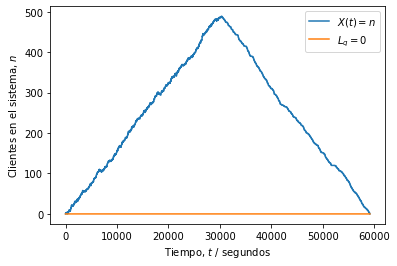

Parámetro lambda = 2.0
Parámetro nu = 1.5
Tiempo con 0 solicitudes en fila:
	 99.35%
	 Sí cumple con la especificación.
Simulación es equivalente a 11.64 horas.


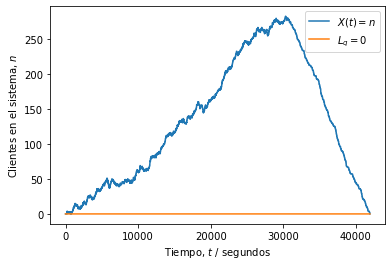

Parámetro lambda = 2.0
Parámetro nu = 2.0
Tiempo con 0 solicitudes en fila:
	 97.70%
	 Sí cumple con la especificación.
Simulación es equivalente a 8.78 horas.


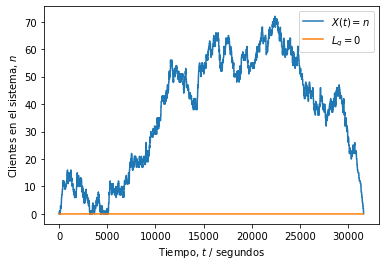

Parámetro lambda = 2.0
Parámetro nu = 2.2222
Tiempo con 0 solicitudes en fila:
	 91.96%
	 Sí cumple con la especificación.
Simulación es equivalente a 8.48 horas.


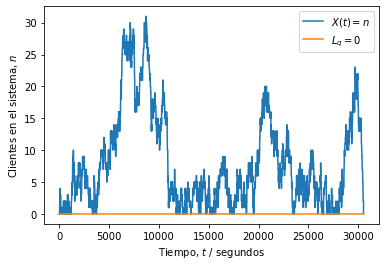

Parámetro lambda = 2.0
Parámetro nu = 3.0
Tiempo con 0 solicitudes en fila:
	 66.99%
	 No cumple con la especificación.
Simulación es equivalente a 8.72 horas.


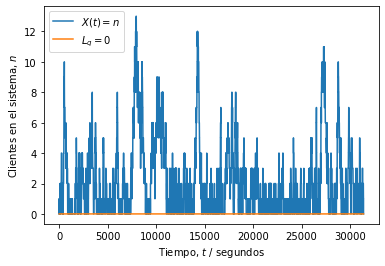

Parámetro lambda = 2.0
Parámetro nu = 5.0
Tiempo con 0 solicitudes en fila:
	 43.52%
	 No cumple con la especificación.
Simulación es equivalente a 8.48 horas.


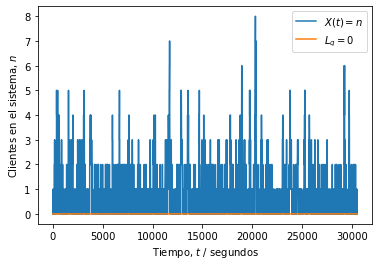

In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Número de clientes
N = 1000

# Parámetro de llegada (clientes/segundos)
lam = 2/60

# Se crea una lista con posibles valores de nu, para corroborar resultados
list = [1, 1.5, 2, 2.2222, 3, 5]

for i in list:
    # Parámetro de servicio (servicios/segundos)
    nu = i/60

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]
    for i in range(1, N):
        inicio = np.max((t_llegadas[i], fin))
        fin = inicio + t_servicio[i]
        t_atencion.append(inicio)

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 1

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    frecuencia = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            frecuencia += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = frecuencia / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    cont = 0
    if P == 1:
        print('Tiempo con {} solicitudes en fila:'.format(cont))
    else:
        print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
    print('\t {:0.2f}%'.format(100*fraccion))
    if fraccion >= 0.90:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    if P == 1: 
        plt.figure()
        plt.plot(Xt)
        plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
        plt.legend(('$X(t) = n$', '$L_q = $' + str(cont)))
        plt.ylabel('Clientes en el sistema, $n$')
        plt.xlabel('Tiempo, $t$ / segundos')
        plt.show()
    else:
        plt.figure()
        plt.plot(Xt)
        plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
        plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
        plt.ylabel('Clientes en el sistema, $n$')
        plt.xlabel('Tiempo, $t$ / segundos')
        plt.show()

#### Conclusión de la simulación

Se utilizaron distintos valores de nu para corroborar lo mencionado anteriromente. Es claro destecar que $\nu$ representa el servicio del servidor web hacia los clientes, entonces se nos indicó mediante las ecuaciones que para una llegada de 2 clientes por minuto, se ha de necesitar al menos 2.222 clientes por segundo para poder mantener un 10% del tiempo total como máximo sin antender clientes. Cabe destacar que al realizar la simulación con un valor de $\nu$ de 2.2222 no asegura un 10% exacto con 0 clientes atendidos, sino ya que al trabajar con distribuciones de variables aleatorias se puede predecir que con ese valor es el necesario para poder ajustar las condiciones requeridas. Entonces, al simular comparando los distintos valores $\nu$ se puede apreciar directamente que para los valores menores de 2.2222 sí se cumplió que haya al menos un 10% del tiempo sin clientes para atender, y a medida que más cercano el valor de $\nu$ sea a cero, menor será el porcentaje de tiempo sin clientes. En cambio al incrementar el valor de $\nu$ quiere decir que son más capaces de atender clientes por minutos, por tanto el tiempo sin clientes para atender se dispararía ya que por ejemplo, con $\nu = 5 \quad y \quad \lambda = 2$, se interpreta que llegan 2 clientes por minuto, pero se es capaz de atender en el servidor web a 5 clientres por minuto; entonces claramente se incrementaría por mucho el tiempo sin clientes en el servidor. 

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---